<a href="https://colab.research.google.com/github/kangnurrohman/belajar-transfer-learning/blob/main/materi/Part%203%20-%20Transfer%20Learning%20with%20PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/data/data 3.zip", 'r')
zip_ref.extractall("data")
zip_ref.close()

In [ ]:
pip install jcopdl luwiji

In [4]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

**Referensi:**

https://towardsdatascience.com/review-mobilenetv2-light-weight-model-image-classification-8febb490e61c

## Dataset & Dataloader

In [5]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from jcopdl.utils.dataloader import MultilabelDataset

In [6]:
bs = 64
crop_size = 224

# train augmentation / data pipeline
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(crop_size, scale=(0.7, 1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# test augmentation / data pipeline
test_transform = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_set = MultilabelDataset('data/train_label.csv', 'data/train/', transform=train_transform)
train_loader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=2)

test_set = MultilabelDataset('data/test_label.csv', 'data/test/', transform=test_transform)
test_loader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [7]:
label2cat = train_set.classes
label2cat

['desert', 'mountains', 'sea', 'sunset', 'trees']

## Arsitektur & Config

**Cara pakai Pretrained-Mobile** 

In [8]:
from torchvision.models import mobilenet_v2

In [9]:
# Load a pretrained-model
mnet = mobilenet_v2(pretrained=True)
# Freeze the feature extractor
for param in mnet.parameters():
  param.requires_grad = False

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [10]:
# cek arsitektur mobilenet_v2 before modify
mnet

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [11]:
# Modify the classifier to our data
mnet.classifier = nn.Sequential(
    nn.Linear(1280, 5),
    nn.Sigmoid()
)

In [12]:
# cek arsitektur mobilenet_v2 after modify
mnet

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [13]:
# custom mobilenet v2
class CustomMobileNetv2(nn.Module):
  def __init__(self, output_size):
    super().__init__()
    self.mnet = mobilenet_v2(pretrained=True) # Load a pretrained-model
    self.frezee() # Freeze the feature extractor
    # Modify the classifier to our data
    self.mnet.classifier = nn.Sequential(
      nn.Linear(1280, output_size),
      nn.Sigmoid()
    )

  def forward(self, x):
    return self.mnet(x)
  
  def frezee(self):
    for param in self.mnet.parameters():
      param.requires_grad = False

  def unfreeze(self):
    for param in self.mnet.parameters():
      param.requires_grad = True

In [14]:
config = set_config({
    "output_size": len(train_set.classes),
    "batch_size" : bs,
    "crop_size"  : crop_size
})

## Phase 1 : Adaptation (lr standard + patience kecil)

In [15]:
model = CustomMobileNetv2(config.output_size).to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, early_stop_patience=2 ,outdir='/content/data/model')

In [16]:
from tqdm import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
  if mode == 'train':
    model.train()
  elif mode == 'test':
    model.eval()
  cost = 0
  for feature, target in tqdm(dataloader, desc=mode.title()):
    feature, target = feature.to(device), target.to(device)
    output = model(feature)
    loss = criterion(output, target)

    if mode == 'train':
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    cost += loss.item() * feature.shape[0]
  cost = cost / len(dataset)
  return cost

Test: 100%|██████████| 7/7 [00:01<00:00,  3.59it/s]



Epoch     1
Train_cost  = 0.5077 | Test_cost  = 0.3984 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  3.56it/s]



Epoch     2
Train_cost  = 0.3557 | Test_cost  = 0.3099 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  3.68it/s]



Epoch     3
Train_cost  = 0.3012 | Test_cost  = 0.2751 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  3.69it/s]



Epoch     4
Train_cost  = 0.2764 | Test_cost  = 0.2578 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  3.65it/s]



Epoch     5
Train_cost  = 0.2608 | Test_cost  = 0.2567 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  3.65it/s]



Epoch     6
Train_cost  = 0.2510 | Test_cost  = 0.2367 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  3.65it/s]



Epoch     7
Train_cost  = 0.2466 | Test_cost  = 0.2431 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2367


Test: 100%|██████████| 7/7 [00:01<00:00,  3.65it/s]



Epoch     8
Train_cost  = 0.2301 | Test_cost  = 0.2303 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  3.57it/s]



Epoch     9
Train_cost  = 0.2291 | Test_cost  = 0.2283 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]



Epoch    10
Train_cost  = 0.2359 | Test_cost  = 0.2231 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  3.61it/s]



Epoch    11
Train_cost  = 0.2243 | Test_cost  = 0.2177 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  3.52it/s]



Epoch    12
Train_cost  = 0.2125 | Test_cost  = 0.2155 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  3.61it/s]



Epoch    13
Train_cost  = 0.2142 | Test_cost  = 0.2146 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  3.60it/s]



Epoch    14
Train_cost  = 0.2082 | Test_cost  = 0.2184 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2146


Test: 100%|██████████| 7/7 [00:02<00:00,  3.49it/s]



Epoch    15
Train_cost  = 0.2138 | Test_cost  = 0.2168 | 
==> EarlyStop patience =  2 | Best test_cost: 0.2146
==> Execute Early Stopping at epoch: 15 | Best test_cost: 0.2146
==> Best model is saved at /content/data/model


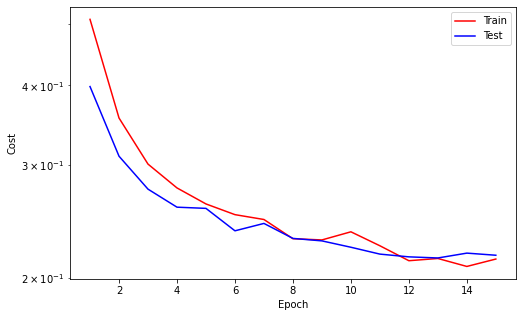

In [17]:
while True:
  train_cost = loop_fn("train", train_set, train_loader, model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost= loop_fn("test", test_set, test_loader, model, criterion, optimizer, device)

  #Logging
  callback.log(train_cost, test_cost)

  #Checkpoint
  callback.save_checkpoint()

  #Runtime_plotting
  callback.cost_runtime_plotting()

  #Early stopping
  if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

## Phase 2: Fine-tuning (lr dikecilin, patience ditambah)

In [18]:
model.unfreeze()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
callback.reset_early_stop()
callback.early_stop_patience = 5

Test: 100%|██████████| 7/7 [00:02<00:00,  3.02it/s]



Epoch    16
Train_cost  = 0.1989 | Test_cost  = 0.2065 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  3.66it/s]



Epoch    17
Train_cost  = 0.1828 | Test_cost  = 0.1983 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]



Epoch    18
Train_cost  = 0.1686 | Test_cost  = 0.1900 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  3.66it/s]



Epoch    19
Train_cost  = 0.1577 | Test_cost  = 0.1858 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  3.66it/s]



Epoch    20
Train_cost  = 0.1545 | Test_cost  = 0.1864 | 


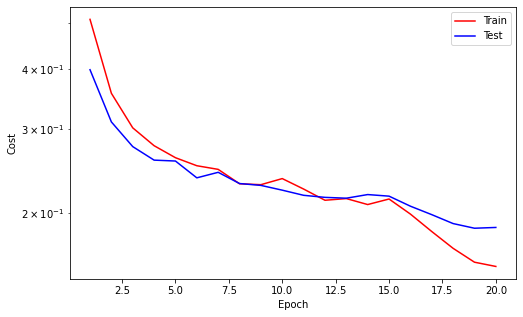

==> EarlyStop patience =  1 | Best test_cost: 0.1858


Test: 100%|██████████| 7/7 [00:01<00:00,  3.69it/s]



Epoch    21
Train_cost  = 0.1432 | Test_cost  = 0.1781 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  3.67it/s]



Epoch    22
Train_cost  = 0.1413 | Test_cost  = 0.1729 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]



Epoch    23
Train_cost  = 0.1391 | Test_cost  = 0.1755 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1729


Test: 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]



Epoch    24
Train_cost  = 0.1298 | Test_cost  = 0.1730 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1729


Test: 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]



Epoch    25
Train_cost  = 0.1249 | Test_cost  = 0.1719 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]



Epoch    26
Train_cost  = 0.1277 | Test_cost  = 0.1648 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  3.67it/s]



Epoch    27
Train_cost  = 0.1196 | Test_cost  = 0.1668 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1648


Test: 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]



Epoch    28
Train_cost  = 0.1155 | Test_cost  = 0.1627 | 


Test: 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]



Epoch    29
Train_cost  = 0.1149 | Test_cost  = 0.1631 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1627


Test: 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]



Epoch    30
Train_cost  = 0.1077 | Test_cost  = 0.1660 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1627


Test: 100%|██████████| 7/7 [00:01<00:00,  3.69it/s]



Epoch    31
Train_cost  = 0.1060 | Test_cost  = 0.1624 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]



Epoch    32
Train_cost  = 0.1006 | Test_cost  = 0.1589 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  3.64it/s]



Epoch    33
Train_cost  = 0.0979 | Test_cost  = 0.1605 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1589


Test: 100%|██████████| 7/7 [00:01<00:00,  3.66it/s]



Epoch    34
Train_cost  = 0.0956 | Test_cost  = 0.1610 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1589


Test: 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]



Epoch    35
Train_cost  = 0.0937 | Test_cost  = 0.1703 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1589


Test: 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]



Epoch    36
Train_cost  = 0.0909 | Test_cost  = 0.1571 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]



Epoch    37
Train_cost  = 0.0869 | Test_cost  = 0.1652 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1571


Test: 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]



Epoch    38
Train_cost  = 0.0842 | Test_cost  = 0.1628 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1571


Test: 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]



Epoch    39
Train_cost  = 0.0852 | Test_cost  = 0.1639 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1571


Test: 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]



Epoch    40
Train_cost  = 0.0833 | Test_cost  = 0.1612 | 


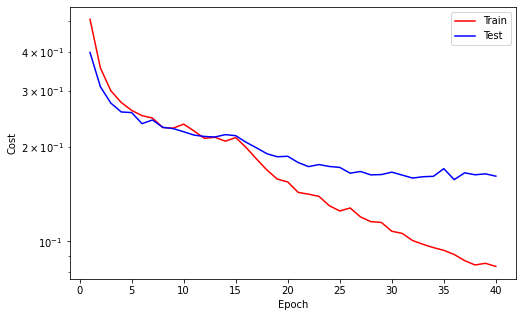

==> EarlyStop patience =  4 | Best test_cost: 0.1571


Test: 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]



Epoch    41
Train_cost  = 0.0800 | Test_cost  = 0.1557 | 


Test: 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]



Epoch    42
Train_cost  = 0.0767 | Test_cost  = 0.1600 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1557


Test: 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]



Epoch    43
Train_cost  = 0.0777 | Test_cost  = 0.1525 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]



Epoch    44
Train_cost  = 0.0716 | Test_cost  = 0.1608 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1525


Test: 100%|██████████| 7/7 [00:01<00:00,  3.63it/s]



Epoch    45
Train_cost  = 0.0717 | Test_cost  = 0.1528 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1525


Test: 100%|██████████| 7/7 [00:01<00:00,  3.63it/s]



Epoch    46
Train_cost  = 0.0712 | Test_cost  = 0.1661 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1525


Test: 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]



Epoch    47
Train_cost  = 0.0697 | Test_cost  = 0.1575 | 
==> EarlyStop patience =  4 | Best test_cost: 0.1525


Test: 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]



Epoch    48
Train_cost  = 0.0625 | Test_cost  = 0.1584 | 
==> EarlyStop patience =  5 | Best test_cost: 0.1525
==> Execute Early Stopping at epoch: 48 | Best test_cost: 0.1525
==> Best model is saved at /content/data/model


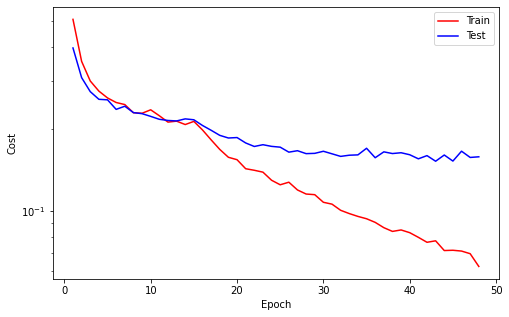

In [19]:
while True:
  train_cost= loop_fn("train", train_set, train_loader, model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost= loop_fn("test", test_set, test_loader, model, criterion, optimizer, device)

  #Logging
  callback.log(train_cost, test_cost)

  #Checkpoint
  callback.save_checkpoint()

  #Runtime_plotting
  callback.cost_runtime_plotting()

  #Early stopping
  if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

## Predict

In [20]:
feature, target = next(iter(test_loader))
feature, target = feature.to(device), target.to(device)

In [21]:
with torch.no_grad():
  model.eval()
  output = model(feature)
  preds = (output > 0.5).to(torch.float32)
preds

tensor([[0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1.],
        [0., 1., 0., 0., 1.],
        [0., 0., 1., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0.],
        [0., 1., 0., 0., 1.],
        [0., 1., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [1

## Sanity Check

In [22]:
def convert_to_label(x):
  return [label for pred, label in zip(x, label2cat) if pred==1]

def inverse_norm(img):
  img[0, :, :] = img[0, :, :] * 0.229 + 0.485
  img[1, :, :] = img[1, :, :] * 0.224 + 0.456
  img[2, :, :] = img[2, :, :] * 0.225 + 0.406
  return img

In [23]:
import matplotlib.pyplot as plt

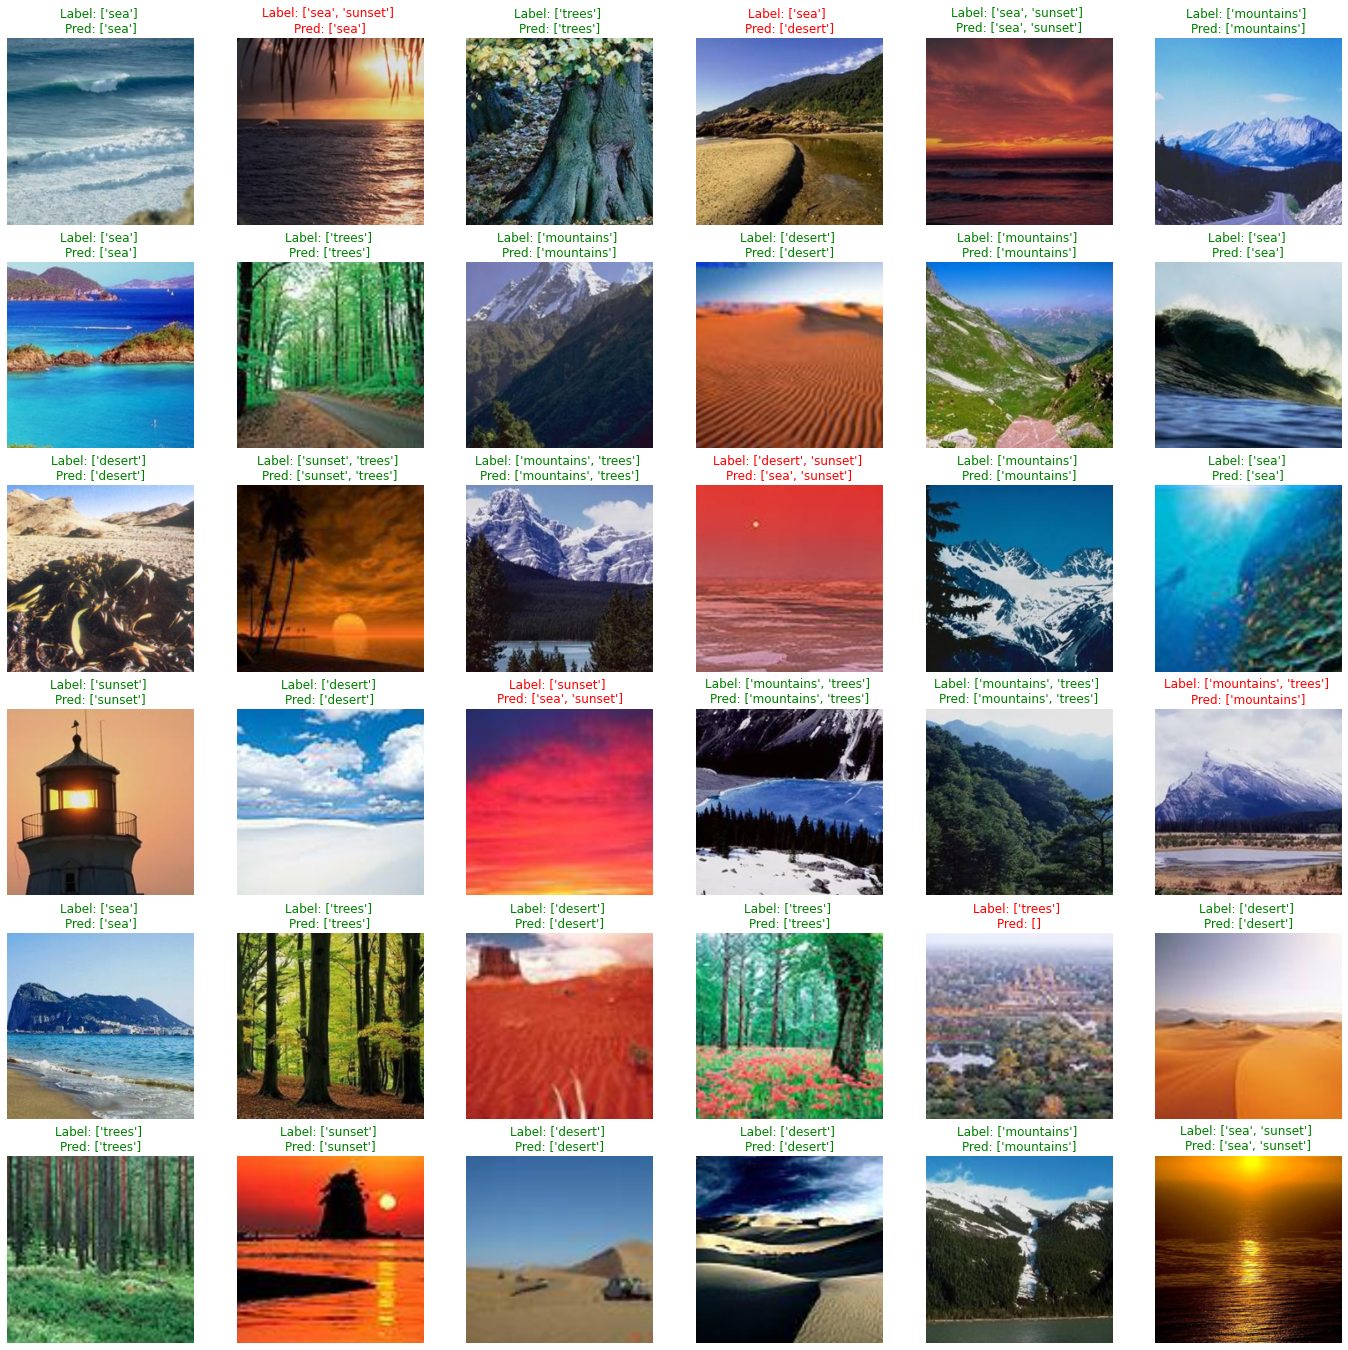

In [24]:
fig, axes = plt.subplots(6, 6, figsize=(24,24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
  ax.imshow(inverse_norm(img).permute(1, 2, 0).cpu())
  font = {"color" : 'r'} if (pred != label).any() else {"color": 'g'}
  label, pred = convert_to_label(label), convert_to_label(pred)
  ax.set_title(f"Label: {label} \nPred: {pred}", fontdict=font);
  ax.axis('off');

In [25]:
!zip -r model.zip /content/data/model

  adding: content/data/model/ (stored 0%)
  adding: content/data/model/configs.pth (deflated 51%)
  adding: content/data/model/weights_best.pth (deflated 8%)
  adding: content/data/model/logs.pth (deflated 21%)
